In [87]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import time
import os
import cv2
import random
import time
import sklearn
from sklearn.utils import class_weight
from sklearn.model_selection import train_test_split
from sklearn import metrics

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

### View Original Image

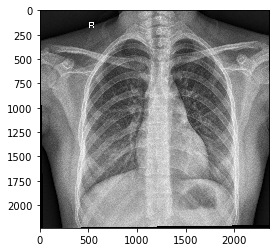

In [2]:
DATADIR = "Data"
CATEGORIES = ["NORMAL", "PNEUMONIA"]
for category in CATEGORIES:
    path = os.path.join(DATADIR,'train/', category)
    for img in os.listdir(path):  # Iterate over every image
        img_array = cv2.imread(os.path.join(path,img) ,cv2.IMREAD_GRAYSCALE) # Convert to array
        plt.imshow(img_array, cmap='gray')
        plt.show()
        # Check to see one image
        break
    break

### Resize Image

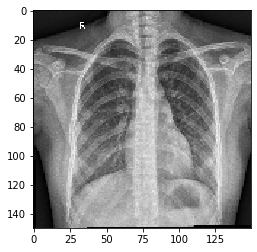

In [3]:
# Check if they are the same size
'''
for category in CATEGORIES:
    path = os.path.join(DATADIR,'train/', category)
    for img in os.listdir(path):  # Iterate over every image
        img_array = cv2.imread(os.path.join(path,img) ,cv2.IMREAD_GRAYSCALE) # Convert to array
        print(img_array.shape)
'''

# Not the same size, need to normalize these images
IMG_SIZE = 150
resized_img = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
plt.imshow(resized_img, cmap='gray')
plt.show()

### Import Dataset

In [88]:
# Create data set
def create_data_set(folder, container):
    for category in CATEGORIES:
        path = os.path.join(DATADIR, folder, category)
        label = CATEGORIES.index(category) # Give label: Pneumonia=1, Normal=0
        for img in os.listdir(path):  # Iterate over every image
            img_array = cv2.imread(os.path.join(path,img), cv2.IMREAD_GRAYSCALE) # Convert to array
            resized_img = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
            container.append([resized_img, label])

training_set = []
create_data_set('train/', training_set)
create_data_set('val/', training_set)
test_set = []
create_data_set('test/', test_set)

training_set, valid_set = train_test_split(training_set, test_size=0.2, random_state=123)

print('Training set size', len(training_set))
print('Validating set size', len(valid_set))
print('Test set size', len(test_set)) # Around 10% of data used for testing

Training set size 4185
Validating set size 1047
Test set size 624


In [89]:
X_train = []
y_train = []
for features, label in training_set:
    X_train.append(features)
    y_train.append(label)
X_train = np.array(X).reshape(-1, IMG_SIZE, IMG_SIZE, 1)
y_train = np.array(y)
X_train=X_train/255

X_valid = []
y_valid = []
for features, label in valid_set:
    X_valid.append(features)
    y_valid.append(label)
X_valid = np.array(X_valid).reshape(-1, IMG_SIZE, IMG_SIZE, 1)
y_valid = np.array(y_valid)
X_valid=X_valid/255

X_test = []
y_test = []
for features, label in test_set:
    X_test.append(features)
    y_test.append(label)
X_test = np.array(X_test).reshape(-1, IMG_SIZE, IMG_SIZE, 1)
y_test = np.array(y_test)
X_test=X_test/255

### Transform Image

In [8]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range = 30,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.15, # randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip = True,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(X_train)

In [9]:
print(len(X_train))

5232


In [11]:
X_train[0].shape

(150, 150, 1)

In [ ]:
os.chdir('Data/')

In [63]:
aug = datagen.flow(x=X_train,
                    y=y_train,
                    batch_size=32,
                    shuffle=True,
                    sample_weight=None,
                    seed=None,
                    #save_to_dir='aug',
                    save_prefix="",
                    save_format="jpeg")
len(aug)

164

In [84]:
X_aug = []
y_aug = []

for i in range(1):
    img = next(aug)
    for pic in img[0]:
        X_aug.append(pic)
    y_aug = np.concatenate((y_aug, img[1]), axis=0)

### Visualize + and - Samples

In [ ]:
# Visualize some samples of positive and negative cases

random.shuffle(training_set) # Run again to look at another sample

pneumonia_samples = []
normal_samples = []
for img in training_set:
    if img[1] == 1:
        pneumonia_samples.append(img[0])
    else:
        normal_samples.append(img[0])
    if len(pneumonia_samples) > 5 and len(normal_samples) > 5:
        break
    

# Concat the data in a single list and del the above two list
samples = pneumonia_samples + normal_samples
del pneumonia_samples, normal_samples

# Plot the data 
f, ax = plt.subplots(2,5, figsize=(30,10))
for i in range(10):
    img = samples[i]
    ax[i//5, i%5].imshow(img, cmap='gray')
    if i<5:
        ax[i//5, i%5].set_title("Pneumonia")
    else:
        ax[i//5, i%5].set_title("Normal")
    ax[i//5, i%5].axis('off')
    ax[i//5, i%5].set_aspect('auto')
plt.show()

Hard to tell difference

### Case Count

In [ ]:
# Check for imbalance
count1 = 0
for data in training_set:
    if data[1]==1:
        count1 += 1
print('Pneumonia count in training set:', round(100*count1/len(training_set),1), '%',
     'out of', len(training_set), 'cases')

count2 = 0
for data in test_set:
    if data[1]==1:
        count2 += 1
print('Pneumonia count in testing set:', round(100*count2/len(test_set),1), '%',
     'out of', len(test_set), 'cases')

The dataset is very unbalanced

In [ ]:
# Plot the results 
x = ['Negative', 'Positive']
y = [len(training_set)-count1, count1]
plt.bar(x, y)
plt.ylabel("Case Count")
plt.title("Pneumonia vs Normal Case Count in Training Set")
plt.show()